# Chapter 5 - Applying Convnets to The Dogs vs Cats

In [17]:
# Importing PlaidML. Make sure you follow this order
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [18]:
from keras.datasets import mnist
from keras import models, layers
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import shutil
import os

import matplotlib.pyplot as plt

In [19]:
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

## Loading dataset

In [20]:
if 'DATASET_CATS_DOGS' in os.environ:
    original_dataset_dir = os.environ['DATASET_CATS_DOGS']
else:
    original_dataset_dir = "/Users/adriano.gil/workspace/datasets/dogs-vs-cats/train/"

if 'DATASET_CATS_DOGS_SMALL' in os.environ:
    base_dir = os.environ["DATASET_CATS_DOGS_SMALL"]
else:
    base_dir = "/Users/adriano.gil/workspace/datasets/dogs-vs-cats-small"
create_dir(base_dir)

In [21]:
train_dir = os.path.join(base_dir, 'train')
create_dir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
create_dir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
create_dir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
create_dir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
create_dir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
create_dir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
create_dir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
create_dir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
create_dir(test_dogs_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [22]:
print('Total training cat images: ', len(os.listdir(train_cats_dir)))
print('Total training dog images: ', len(os.listdir(train_dogs_dir)))
print('Total validation cat images: ', len(os.listdir(validation_cats_dir)))
print('Total validation dog images: ', len(os.listdir(validation_dogs_dir)))
print('Total test cat images: ', len(os.listdir(test_cats_dir)))
print('Total test dogs images: ', len(os.listdir(test_dogs_dir)))

Total training cat images:  1000
Total training dog images:  1000
Total validation cat images:  500
Total validation dog images:  500
Total test cat images:  500
Total test dogs images:  500


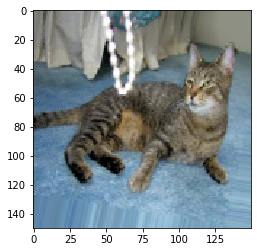

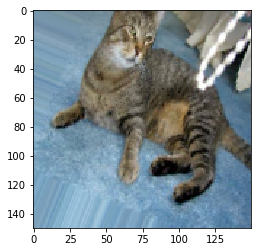

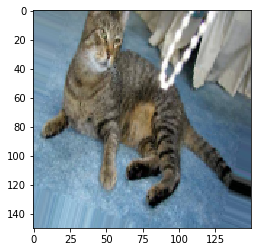

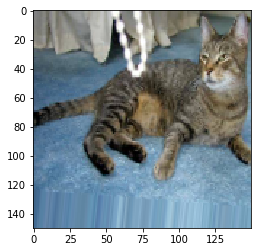

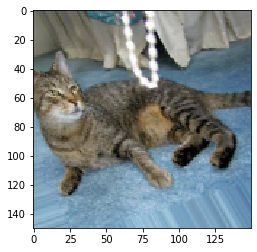

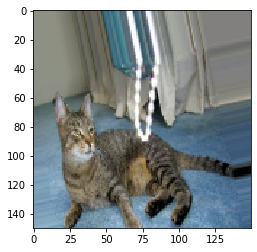

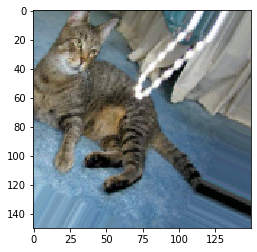

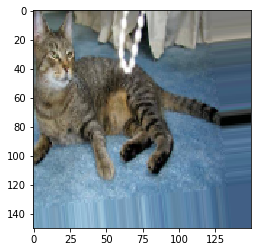

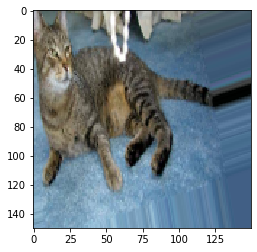

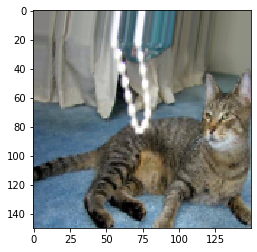

In [23]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

fnames = [os.path.join(train_cats_dir, fname) for
    fname in os.listdir(train_cats_dir)]

# Chooses one image to augment
img_path = fnames[3]

img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 10 == 0:
        break
plt.show()

## Preparing data (using data-augumentation generators)

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Generating Models

In [9]:
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=optimizers.RMSprop(lr=1e-4),
        loss='binary_crossentropy',
        metrics=['acc']
    )
    return model

In [10]:
model = build_model()
model.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D) 

## Training model

In [12]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)
model.save('catas_and_dogs_small_2.h5')

Epoch 1/100
100/100 [==============================] - 23s 226ms/step - loss: 0.6943 - acc: 0.5090 - val_loss: 0.6956 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 18s 183ms/step - loss: 0.6889 - acc: 0.5360 - val_loss: 0.6953 - val_acc: 0.5000
Epoch 3/100
100/100 [==============================] - 19s 192ms/step - loss: 0.6804 - acc: 0.5695 - val_loss: 0.6608 - val_acc: 0.6220
Epoch 4/100
100/100 [==============================] - 18s 185ms/step - loss: 0.6731 - acc: 0.5790 - val_loss: 0.6489 - val_acc: 0.6170
Epoch 5/100
100/100 [==============================] - 20s 196ms/step - loss: 0.6599 - acc: 0.6075 - val_loss: 0.6461 - val_acc: 0.6120
Epoch 6/100
100/100 [==============================] - 31s 311ms/step - loss: 0.6449 - acc: 0.6140 - val_loss: 0.6168 - val_acc: 0.6560
Epoch 7/100
100/100 [==============================] - 25s 253ms/step - loss: 0.6372 - acc: 0.6380 - val_loss: 0.6048 - val_acc: 0.6640
Epoch 8/100
100/100 [===========================

## Displaying curves of loss and accuracy during training

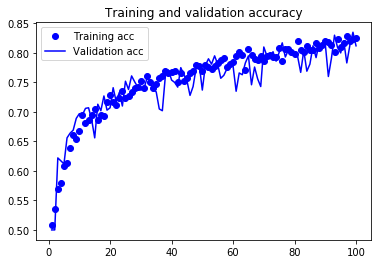

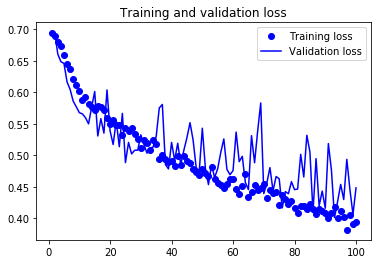

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
